In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [3]:
import numpy as np
from time import time
from operator import mul
from functools import reduce
from itertools import count
from munch import Munch
from itertools import zip_longest
import logging
import multiprocessing as mp

import re
from pathlib import Path

import scipy
from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes, normalise_IPR
from FKMC.stats import binned_error_estimate_multidim, product
from FKMC.import_funcs import allocate, copy, reshape, execute_script, ProgressReporter, shape_hints, timefmt, update_description
from FKMC.import_funcs import  mean_over_MCMC, IPRandDOS, extract

#variable classifications
N_dependent_size = set(['IPRs', 'eigenvals', 'state','accept_rates', 'classical_accept_rates', 'last_state', 'proposal_rates'])
per_step = set([ 'Fc', 'Ff', 'Mf_moments', 'Nc', 'Nf', 'eigenval_bins'])
per_run = set(['A', 'N_cumulants','time'])

from collections import defaultdict


def datafile_load(filename):
    return np.load(filename, allow_pickle = True)['logs']

def datafile_concat(datafiles, Ns):
    #datafiles is a list of lists where the outer is chain_ext and inner is Ns
    datafile = [Munch() for _ in Ns]
    names = ['IPRs', 'eigenvals', 'Mf_moments', 'eigenval_bins', 'time', 'accept_rates', 'proposal_rates']
    
    for name in names:
        if not hasattr(datafiles[0][0], name): continue
        shape = shape_hints(name)
        if 'MCstep' in shape:
            axis = shape.index('MCstep')
        for i, N in enumerate(Ns):
            if name == 'time':
                datafile[i][name] = np.sum([getattr(log[i], name) for log in datafiles])
            elif name == 'eigenval_bins':
                log = datafiles[0]
                datafile[i][name] = getattr(log[i], name)
            else:
                datafile[i][name] = np.concatenate([getattr(log[i], name) for log in datafiles], axis = axis)
    return datafile

def get_data_funcmap_chain_ext(this_run,
            functions = [],
            strict_chain_length = True,
            chain_length = None,
            ):
    
    '''
    '''
    this_run = this_run.expanduser()
    logger.warning(f'looking in {this_run}')
    data = this_run / 'data'
    code = this_run / 'code'
    
    #get the batch params from the original script
    print(list(code.glob('*.py')))
    py_script = next(code.glob('*.py'))
    context = execute_script(py_script)
    batch_params = Munch(context.batch_params)
    structure_names = batch_params.structure_names
    structure_dims = tuple(d.size for d in batch_params.structure_dimensions)
    
    logger.debug(f'structure_names = {structure_names}')
    logger.debug(f'structure_dims = {structure_dims}')
    
    #calculate the epected number of jobs
    def name2id(n): return tuple(map(int,n.split('_')))
    
    datafiles = dict()
    task_ids = set()
    chain_ids = defaultdict(set)
    for f in data.glob('*.npz'):
        task_id, chain_id = name2id(f.stem)
        datafiles[(task_id, chain_id)] = f
        task_ids.add(task_id)
        chain_ids[task_id].add(chain_id)
    
    
    N_tasks = product(structure_dims)
    
    N_chains = min(max(c) for c in chain_ids.values()) + 1
    
    logger.debug(f'Expected number of tasks {N_tasks}')
    logger.debug(f'Measured number of tasks {len(task_ids)}')
    logger.debug(f'Expected number of chains {chain_length}')
    logger.debug(f'Measured number of chains {N_chains}')
    if chain_length is not None: N_chains = chain_length
    
    functions += [extract('time'), 
                  mean_over_MCMC('accept_rates', N_error_bins = 1),
                  mean_over_MCMC('proposal_rates', N_error_bins = 1)]
    
    if len(datafiles) == 0: 
        logger.error("NO DATA FILES FOUND");
        return
    
    #get stuff from an an example datafile
    d = Munch(np.load(next(iter(datafiles.values())), allow_pickle = True))
    Ns = d['Ns']
    parameters = d['parameters'][()]
    MCMC_params = d['MCMC_params'][()]
    
    logger.info(f'Logger keys: {list(d.keys())} \n')
    logger.info(f"MCMC_params keys: {list(MCMC_params.keys())} \n")
    
    original_N_steps = MCMC_params['N_steps']
    thin = MCMC_params['thin']
    N_steps = original_N_steps // thin
    
    logger.debug(list(zip(count(), structure_names, structure_dims)))

    possible_observables = [s for s in dir(d.logs[0]) if not s.startswith("_")]
    logger.info(f'available observables = {possible_observables}')
    
    logger.debug(f'Allocating space for the requested observables:')
    observables = Munch()
    for f in functions: f.allocate(observables, example_datafile = d, N_jobs = N_tasks)
    
    #copy extra info over, note that structure_names might appear as a key in d, but I just overwrite it for now
    observables.update({k : v[()] for k,v in d.items() if k != 'logs'})
    observables.structure_names = structure_names
    observables.structure_dims = structure_dims
    observables.batch_params = batch_params
    observables['hints'] = Munch() 
    
    for name, dim in zip(structure_names, batch_params.structure_dimensions):
        observables[name] = dim
    
    with mp.Pool(18) as p:
        for task_id in range(N_tasks):
            print(task_id, end = ' ')

            filename_list = [data / f'{task_id}_{chain_id}.npz' for chain_id in  range(N_chains)]
            
            def check_exists(f):
                if not f.exists(): 
                    raise ValueError(f'{f} is expected but missing!')
            map(check_exists, filename_list)

            datafile_list = list(p.map(datafile_load, filename_list))

            #datafile_list = list(map(datafile_load, filename_list))
            
            #check that the final N is present in all the datafiles
            finished = [d[-1] is not None for d in datafile_list]
            if not all(finished):
                print(f'not all of {task_id} is not finished')
                print(finished)
                continue
            
            #for d in datafile_list: print(d[-1].accept_rates.shape)
            datafile = datafile_concat(datafile_list, Ns)
            

            #convert all those datafiles to one
            for f in functions: f.copy(observables, task_id, datafile)


    
    for f in functions:
        f.reshape(structure_dims, observables)
    
   
    logger.info('########################################################################\n')
    logger.info(f'Observables has keys: {observables.keys()}')
    
    o = observables = Munch(observables)
    
    infostring = \
    f"""
    Completed jobs:?
    MCMC Steps: {original_N_steps} with thinning = {thin} for {N_steps} recorded steps
    Burn in: {Munch(MCMC_params).N_burn_in}
    Structure_names: {dict(zip(structure_names, structure_dims))}
    Ns = {Ns}
    Runtimes: 
        Average: {timefmt(np.nanmean(o.time.sum(axis=0)))}
        Min: {timefmt(np.nanmin(o.time.sum(axis=0)))}
        Max: {timefmt(np.nanmax(o.time.sum(axis=0)))}
        Total: {timefmt(np.nansum(o.time))}
    """[1:]
    logger.info(infostring)
    update_description(this_run.stem, infostring)
    
    return observables

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

oTsweep_binder = get_data_funcmap_chain_ext(Path('~/HPC_data/Tsweep3_binder'),
            functions = [
                mean_over_MCMC('Mf_moments', N_error_bins = 10),
                            ],
                #chain_length = 19,
            )

DEBUG:root:structure_names = ['Rs', 'Ts']
DEBUG:root:structure_dims = (10, 25)
DEBUG:root:Expected number of tasks 250
DEBUG:root:Measured number of tasks 250
DEBUG:root:Expected number of chains None
DEBUG:root:Measured number of chains 20
INFO:root:Logger keys: ['Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'logs', 'allow_pickle', 'desc'] 

INFO:root:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

DEBUG:root:[(0, 'Rs', 10), (1, 'Ts', 25)]
INFO:root:available observables = ['A', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'accept_rates', 'classical_accept_rates', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'time', 'update']
DEBUG:root:Allocating space for the requested observables:
DEBUG:FKMC.import_funcs:observables['Mf_moments'] = np.array(shape = (8, 250, 5), dtype = float64) approx size: 0.00Gb
INFO:FKMC.import_funcs:observables['ti

[PosixPath('/rds/general/user/tch14/home/HPC_data/Tsweep3_binder/code/varyingT_binder_zoom.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 20,

Each doing 5000 steps,

100000 total chain length,

10000 samples,


MCMC_params:  N_steps=5000, N_burn_in=5000, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2ba0100cc560>, accept_function=<function perturbation_accept at 0x2ba0100cc8c0>, warnings=False,
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 1

INFO:root:########################################################################

INFO:root:Observables has keys: dict_keys(['Mf_moments', 'sigma_Mf_moments', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'Rs', 'Ts'])
INFO:root:    Completed jobs:?
    MCMC Steps: 5000 with thinning = 10 for 500 recorded steps
    Burn in: 0
    Structure_names: {'Rs': 10, 'Ts': 25}
    Ns = [ 10  20  30  50  70 110 160 250]
    Runtimes: 
        Average: 9.0 hours
        Min: 2.0 hours
        Max: 1.0 days
        Total: 14.0 weeks
    


In [4]:
%%time
logging.basicConfig()
logger = logging.getLogger('local')
logger.setLevel(logging.DEBUG)

oSingle = get_data_funcmap_chain_ext(Path('~/HPC_data/IPR_DOR_U5_J5_above_below_Tc'),
            functions = [
                IPRandDOS(E_bins = np.linspace(-20, 20, 10000 + 1)), 
                mean_over_MCMC('Mf_moments'),
                            ],
            )

DEBUG:local:structure_names = ['Ts']
DEBUG:local:structure_dims = (4,)
DEBUG:local:Expected number of tasks 4
DEBUG:local:Measured number of tasks 4
DEBUG:local:Expected number of chains None
DEBUG:local:Measured number of chains 10
INFO:local:Logger keys: ['Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'logs', 'allow_pickle', 'desc'] 

INFO:local:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

DEBUG:local:[(0, 'Ts', 4)]
INFO:local:available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
DEBUG:local:Allocating space for the requested observables:
DEBUG:FKMC.import_funcs:observables['IPRs'] = np.array(shape = (10, 4, 10000), dtype = <class 'numpy.floa

[PosixPath('/rds/general/user/tch14/home/HPC_data/IPR_DOR_U5_J5_above_below_Tc/code/single.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 10,

Each doing 10000 steps,

100000 total chain length,

1000 samples,


MCMC_params:  N_steps=10000, N_burn_in=10000, thin=100, proposal=<function p_multi_site_uniform_reflect at 0x2ba0100cc560>, accept_function=<function perturbation_accept at 0x2ba0100cc8c0>, warnings=False,
0 1 2 3 

INFO:local:########################################################################

INFO:local:Observables has keys: dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'Ts'])
INFO:local:    Completed jobs:?
    MCMC Steps: 10000 with thinning = 100 for 100 recorded steps
    Burn in: 10000
    Structure_names: {'Ts': 4}
    Ns = [ 70  80  90 110 130 150 180 210 250 300]
    Runtimes: 
        Average: 1.0 days
        Min: 15.0 hours
        Max: 4.0 days
        Total: 6.0 days
    


CPU times: user 12.4 s, sys: 4.05 s, total: 16.5 s
Wall time: 17.1 s


In [4]:
o = oSingle
o.keys()

dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'Ts'])

[1.  1.5 2.  2.5]


Text(0.5, 0.98, 'T = 1.0, J = 5, U = 5, M**2 = 0.56')

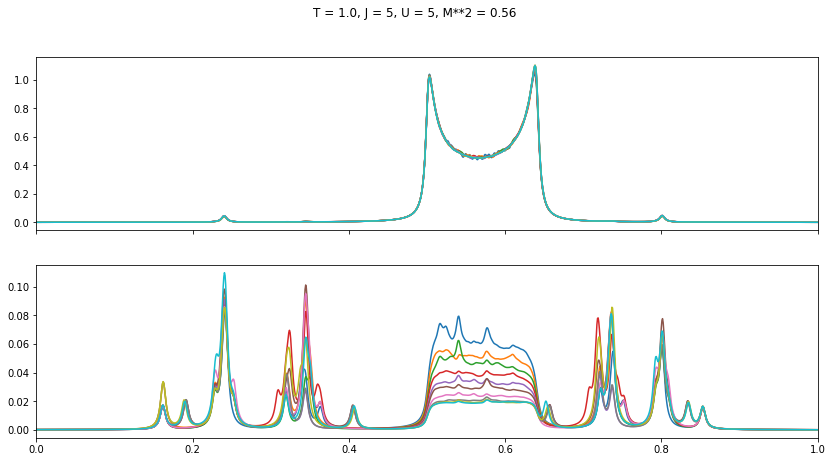

In [5]:
from copy import deepcopy
o = oSmoothed = deepcopy(oSingle)


for i, N in zip(count(), o.Ns):
    scale = 0.1
    for name in ['DOS', 'IPR', 'dDOS', 'dIPR']:
        o[name][i] = smooth(o[name][i], scale)


f, axes = plt.subplots(2,1, sharex = True, figsize = (14,7))
T_select = 0

print(o.Ts)
for i, N in enumerate(o.Ns):
    axes[0].plot(o.E_bins[1:] / o.parameters.U, o.DOS[i, T_select, :], label = f'N = {N}')
    axes[1].plot(o.E_bins[1: ] / o.parameters.U, o.IPR[i, T_select, :],)

axes[0].set(xlim = (0, 1))
f.suptitle(f'T = {o.Ts[T_select]}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [6]:
o.hints.Mf_moments, o.sigma_Mf_moments.shape

(('Ns', 'Ts', 'nth moment'), (10, 4, 5))

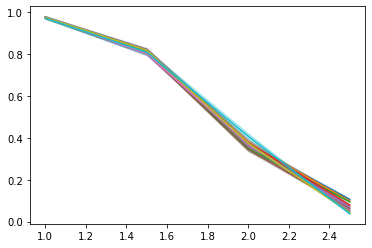

In [6]:
from FKMC.plotting import spread
o = oSingle
f, ax = plt.subplots()

for i, N in enumerate(o.Ns):
    spread(ax, o.Ts, o.Mf_moments[i, :, 2], o.sigma_Mf_moments[i, :, 2], alpha = 0.3, label = f'N = {N}')

In [15]:
%%time
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

oTsweep_fullrange = get_data_funcmap_chain_ext(Path('~/HPC_data/Tsweep3_full'),
            functions = [
                mean_over_MCMC('Mf_moments', N_error_bins = 10),
                            ],
            chain_length = 4,
            )

DEBUG:root:structure_names = ['Rs', 'Ts']
DEBUG:root:structure_dims = (10, 25)
DEBUG:root:Expected number of tasks 250
DEBUG:root:Measured number of tasks 250
DEBUG:root:Expected number of chains 4
DEBUG:root:Measured number of chains 5
INFO:root:Logger keys: ['Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'logs', 'allow_pickle', 'desc'] 

INFO:root:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

DEBUG:root:[(0, 'Rs', 10), (1, 'Ts', 25)]
INFO:root:available observables = ['A', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'accept_rates', 'classical_accept_rates', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'time', 'update']
DEBUG:root:Allocating space for the requested observables:
DEBUG:FKMC.import_funcs:observables['Mf_moments'] = np.array(shape = (8, 250, 5), dtype = float64) approx size: 0.00Gb
INFO:FKMC.import_funcs:observables['time']

[PosixPath('/rds/general/user/tch14/home/HPC_data/Tsweep3_full/code/varyingT_full.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 10,

Each doing 5000 steps,

50000 total chain length,

5000 samples,


MCMC_params:  N_steps=5000, N_burn_in=5000, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2ba0100cc560>, accept_function=<function perturbation_accept at 0x2ba0100cc8c0>, warnings=False,
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 

INFO:root:########################################################################

INFO:root:Observables has keys: dict_keys(['Mf_moments', 'sigma_Mf_moments', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'Rs', 'Ts'])
INFO:root:    Completed jobs:?
    MCMC Steps: 5000 with thinning = 10 for 500 recorded steps
    Burn in: 0
    Structure_names: {'Rs': 10, 'Ts': 25}
    Ns = [ 10  20  30  50  70 110 160 250]
    Runtimes: 
        Average: 4.0 hours
        Min: 31.0 minutes
        Max: 15.0 hours
        Total: 6.0 weeks
    


248 249 CPU times: user 4.56 s, sys: 457 ms, total: 5.02 s
Wall time: 8.85 s


In [10]:
%%time
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

oTsweep_binder = get_data_funcmap_chain_ext(Path('~/HPC_data/Tsweep3_binder'),
            functions = [
                mean_over_MCMC('Mf_moments', N_error_bins = 1),
                            ],
            )

DEBUG:root:structure_names = ['Rs', 'Ts']
DEBUG:root:structure_dims = (10, 25)
DEBUG:root:Expected number of tasks 250
DEBUG:root:Measured number of tasks 250
DEBUG:root:Expected number of chains None
DEBUG:root:Measured number of chains 20
INFO:root:Logger keys: ['Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'logs', 'allow_pickle', 'desc'] 

INFO:root:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

DEBUG:root:[(0, 'Rs', 10), (1, 'Ts', 25)]
INFO:root:available observables = ['A', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'accept_rates', 'classical_accept_rates', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'time', 'update']
DEBUG:root:Allocating space for the requested observables:
DEBUG:FKMC.import_funcs:observables['Mf_moments'] = np.array(shape = (8, 250, 5), dtype = float64) approx size: 0.00Gb
INFO:FKMC.import_funcs:observables['ti

[PosixPath('/rds/general/user/tch14/home/HPC_data/Tsweep3_binder/code/varyingT_binder_zoom.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 20,

Each doing 5000 steps,

100000 total chain length,

10000 samples,


MCMC_params:  N_steps=5000, N_burn_in=5000, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2ba0100cc560>, accept_function=<function perturbation_accept at 0x2ba0100cc8c0>, warnings=False,
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 1

INFO:root:########################################################################

INFO:root:Observables has keys: dict_keys(['Mf_moments', 'sigma_Mf_moments', 'time', 'accept_rates', 'sigma_accept_rates', 'proposal_rates', 'sigma_proposal_rates', 'Ns', 'parameters', 'MCMC_params', 'structure_names', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'structure_dims', 'batch_params', 'hints', 'Rs', 'Ts'])
INFO:root:    Completed jobs:?
    MCMC Steps: 5000 with thinning = 10 for 500 recorded steps
    Burn in: 0
    Structure_names: {'Rs': 10, 'Ts': 25}
    Ns = [ 10  20  30  50  70 110 160 250]
    Runtimes: 
        Average: 9.0 hours
        Min: 2.0 hours
        Max: 1.0 days
        Total: 14.0 weeks
    


CPU times: user 5.47 s, sys: 820 ms, total: 6.29 s
Wall time: 18.4 s


(8, 10, 25, 5)
(8, 10, 25, 5)


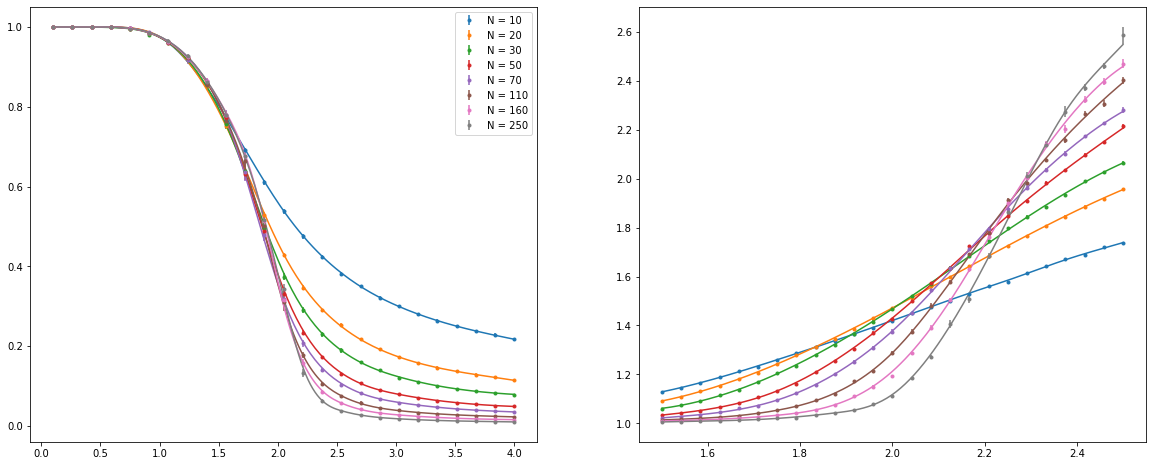

In [36]:
from FKMC.plotting import spread
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.stats import sem

f, axes = plt.subplots(1,2, figsize = (20,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap = plt.get_cmap('viridis')

#Ns_to_keep = [10, 20, 30, 50, 80, 110, 180, 250]
BT_sel = slice(None, None, 1)
MT_sel = slice(None, None, 1)


d = Munch()

o = oTsweep_fullrange
axname = Munch(zip(o.hints.Mf_moments, count()))
print(axes)
print(o.Mf_moments.shape)

d.Ns = o.Ns
d.MX = o.Ts[MT_sel]
M2 = o.Mf_moments[..., MT_sel, 2]
d.M2 =  np.mean(M2, axis = axname.Rs)
d.dM2 = sem(M2, axis = axname.Rs)

o = oTsweep_binder
axname = Munch(zip(o.hints.Mf_moments, count()))
print(axes)
print(o.Mf_moments.shape)

d.BX = o.Ts[BT_sel]
B = o.Mf_moments[..., BT_sel, 4] / o.Mf_moments[..., BT_sel, 2]**2
d.B =  np.mean(B, axis = axname.Rs)
d.dB = sem(B, axis = axname.Rs)




for i, N in enumerate(d.Ns):
    #calculate the spline fits
    #some of the errors come out as zero so clamp to them a reasonable nonzero value
    #which I choose to be 10% of the mean error
    d.dM2[i] = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
    d.dB[i] = np.maximum(d.dB[i], d.dB[i].mean() * 0.1)
    
    M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(d.dM2[i] + 0.01*max(d.dM2[i])), s = len(d.MX))
    binder_interped = UnivariateSpline(d.BX, d.B[i], w = 1/d.dB[i], s = len(d.BX))
    
    color = colors[i]
    
    #plot the full range of M squared
    axes[0].errorbar(d.MX, d.M2[i], yerr = d.dM2[i] * 2, color = color, linestyle = "None", marker = '.', label = f'N = {N}')
    
    x = np.linspace(d.MX[0], d.MX[-1], 200)
    axes[0].plot(x, M_interped(x), color = color)
    
    #spread(axes[0], d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f'N = {N}', color = color)
    
    #plot the binder cumulant
    axes[1].errorbar(d.BX, d.B[i], yerr = d.dB[i], color = color, linestyle = "None", marker = '.')
    #axes[1].plot(d.BX, d.B[i], label = f'N = {N}', color = color)
    
    x = np.linspace(d.BX[0], d.BX[-1], 200)
    axes[1].plot(x, binder_interped(x), color = color)
    
#axes[1].set(xlim = (1.5, 2.5)    )
axes[0].legend()    
import pickle
with open('/home/tch14/HPC_data/pickled_data/binder_data.pickle', 'wb') as file: 
    pickle.dump(d.toDict(), file)